In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [31]:
# Load the data
train_labels = pd.read_csv('/Users/vamsi/venv-metal/interpret.ai/dataset/Training/training_labels.csv')

# Define image size
IMG_SIZE = 128

def load_images(data_dir, file_names):
    images = []
    for file_name in file_names:
        img_path = os.path.join(data_dir, file_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Skip if the image is not found
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        images.append(img)
    return np.array(images)

# Load training images
train_images = load_images('/Users/vamsi/venv-metal/interpret.ai/dataset/Training/training_words', train_labels['IMAGE'])

# Normalize images
train_images = train_images / 255.0

In [32]:
# Encode labels
label_encoder = LabelEncoder()
train_labels['MEDICINE_NAME_ENCODED'] = label_encoder.fit_transform(train_labels['MEDICINE_NAME'])
train_labels_encoded = to_categorical(train_labels['MEDICINE_NAME_ENCODED'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)

# Reshape data for the model
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)


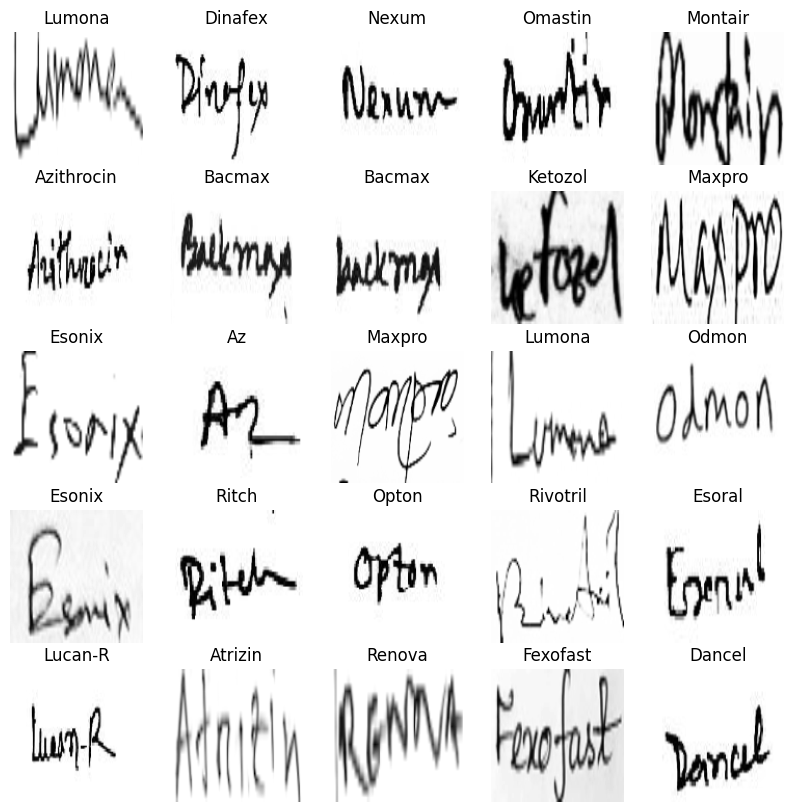

In [33]:
# Visualize some images and their labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(label_encoder.inverse_transform([np.argmax(y_train[i])])[0])
    plt.axis('off')
plt.show()

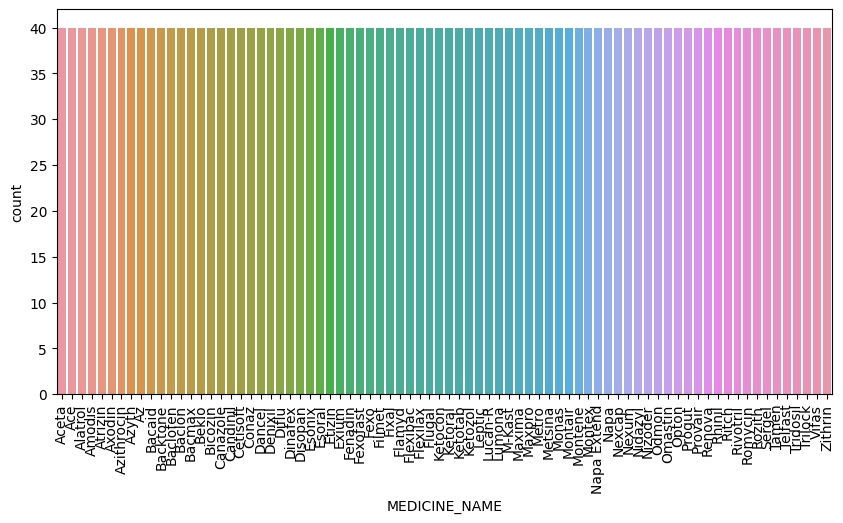

In [34]:
# Visualize label distribution
plt.figure(figsize=(10,5))
sns.countplot(x=train_labels['MEDICINE_NAME'])
plt.xticks(rotation=90)
plt.show()

In [35]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [36]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [37]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)


In [42]:
# Fit the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=200,callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/200
78/78 [==============================] - 3s 37ms/step - loss: 2.5252 - accuracy: 0.4319 - val_loss: 1.5836 - val_accuracy: 0.6250 - lr: 1.0000e-04
Epoch 2/200
78/78 [==============================] - 3s 35ms/step - loss: 2.6402 - accuracy: 0.4223 - val_loss: 1.5366 - val_accuracy: 0.6378 - lr: 1.0000e-04
Epoch 3/200
78/78 [==============================] - 3s 36ms/step - loss: 2.5931 - accuracy: 0.4339 - val_loss: 1.4846 - val_accuracy: 0.6426 - lr: 1.0000e-04
Epoch 4/200
 1/78 [..............................] - ETA: 3s - loss: 2.4711 - accuracy: 0.4062

/Users/vamsi/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 3s 35ms/step - loss: 2.5834 - accuracy: 0.4131 - val_loss: 1.5352 - val_accuracy: 0.6298 - lr: 1.0000e-04
Epoch 5/200
78/78 [==============================] - 3s 35ms/step - loss: 2.5029 - accuracy: 0.4291 - val_loss: 1.5977 - val_accuracy: 0.6154 - lr: 1.0000e-04
Epoch 6/200
78/78 [==============================] - 3s 35ms/step - loss: 2.5819 - accuracy: 0.4062 - val_loss: 1.5734 - val_accuracy: 0.6314 - lr: 1.0000e-04
Epoch 7/200
78/78 [==============================] - 3s 35ms/step - loss: 2.5579 - accuracy: 0.4159 - val_loss: 1.4951 - val_accuracy: 0.6522 - lr: 1.0000e-04
Epoch 8/200
78/78 [==============================] - 3s 35ms/step - loss: 2.5220 - accuracy: 0.4375 - val_loss: 1.5661 - val_accuracy: 0.6314 - lr: 1.0000e-04


20/20 [==============================] - 0s 14ms/step - loss: 1.4846 - accuracy: 0.6426
Validation accuracy: 0.6426281929016113


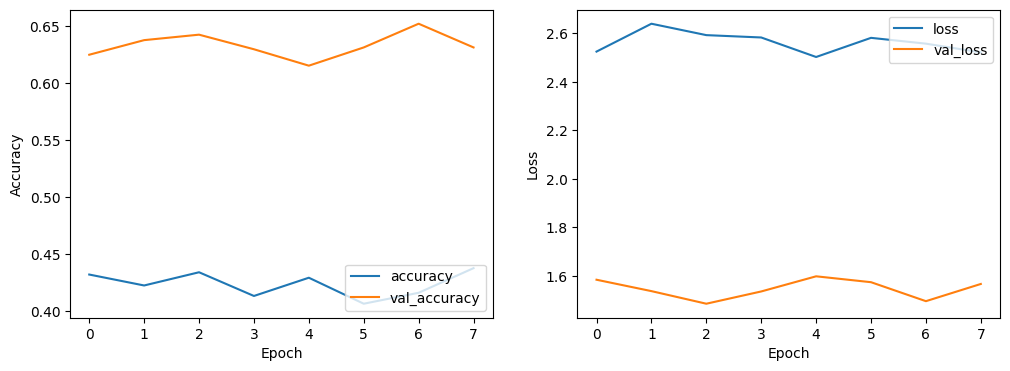

In [43]:
# Evaluate the model
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [44]:
# Load test data and make predictions
test_images = load_images('/Users/vamsi/venv-metal/interpret.ai/dataset/Testing/testing_words', os.listdir('/Users/vamsi/venv-metal/interpret.ai/dataset/Testing/testing_words'))
test_images = test_images / 255.0
test_images = test_images.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

predictions = model.predict(test_images)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))


25/25 [==============================] - 0s 11ms/step


In [45]:
# Save predictions
test_filenames = os.listdir('/Users/vamsi/venv-metal/interpret.ai/dataset/Testing/testing_words')
predictions_df = pd.DataFrame({'IMAGE': test_filenames, 'PREDICTED_MEDICINE_NAME': predicted_labels})
predictions_df.to_csv('test_predictions_2.csv', index=False)


In [46]:
np.save('classes.npy', label_encoder.classes_)